In [1]:
from FlowCytometryTools import *
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import random

sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline
#note: this code requires data from Figure 2 in addition to the Supp Fig 3 Data
#save Suppfig3_Data folder in the same location as this notebook 
dataRepo = os.getcwd() + "/SuppFig3_Data/"
#this assumes Figure2_Data is in the same parent directory as the FigureS3 code and data
dataRepo1 = os.path.dirname(os.getcwd()) + "/Figure2/Figure2_Data/"

# Supplementary Figure 3A

In [2]:
date0 = '20181129_30_1203'
#load platemaps which detail the location of each strain and dose
p2Map_1129, pDarkMap_1129 = [pd.read_csv(x) for x in 
                                    glob.glob(dataRepo + '20181129_LVTRPLANS_ManyTFs_ampResp/PlateMap*.csv')]
p1Map_1130, p2Map_1130, pDarkMap_1130 = [pd.read_csv(x) for x in 
                                    glob.glob(dataRepo + '20181130_LVTRPLANS_ManyTFs_ampResp/PlateMap*.csv')]
p1Map_1203, p2Map_1203, pDarkMap_1203 = [pd.read_csv(x) for x in 
                                    glob.glob(dataRepo + '20181203_LVTRPLANS_ManyTFs_ampResp/PlateMap*.csv')]

In [3]:
#save the names of the directories which hold the actual flow cytometry data
datadir_1129_1 = dataRepo + '20181129_LVTRPLANS_ManyTFs_ampResp/P2_Flat/'
datadir_1129_2 = dataRepo + '20181129_LVTRPLANS_ManyTFs_ampResp/PDark_Flat/'
datadir_1130_1 = dataRepo + '20181130_LVTRPLANS_ManyTFs_ampResp/P1_Flat/'
datadir_1130_2 = dataRepo + '20181130_LVTRPLANS_ManyTFs_ampResp/P2_Flat/'
datadir_1130_3 = dataRepo + '20181130_LVTRPLANS_ManyTFs_ampResp/PDark_Flat/'
datadir_1203_1 = dataRepo + '20181203_LVTRPLANS_ManyTFs_ampResp/P1_Flat/'
datadir_1203_2 = dataRepo + '20181203_LVTRPLANS_ManyTFs_ampResp/P2_Flat/'
datadir_1203_3 = dataRepo + '20181203_LVTRPLANS_ManyTFs_ampResp/PDark_Flat/'

In [4]:
datadir_list_3a = [datadir_1129_1, datadir_1129_2, datadir_1130_1, datadir_1130_2, datadir_1130_3, 
                   datadir_1203_1, datadir_1203_2, datadir_1203_3]
[files_1129_1, files_1129_2, files_1130_1, files_1130_2, files_1130_3, 
                   files_1203_1, files_1203_2, files_1203_3] = [glob.glob(x + '*.fcs') for x in datadir_list_3a]

In [5]:
rows = ['A','B','C','D','E','F','G','H']
cols = ['01','02','03','04','05','06','07','08','09','10','11','12']

In [6]:
def parseFilenamesPlateRaw(files_list, plateraw_list):
    #parse file names to get plate location
    #modifies plateraw_list in place
    for file_plate_ind in range(len(files_list)):
        for i in range(len(files_list[file_plate_ind])):
            c = files_list[file_plate_ind][i][-6:-4]
            r = files_list[file_plate_ind][i][-7]
            call = r + c
            plateraw_list[file_plate_ind].loc[r,c] = FCMeasurement(ID = call, datafile = files_list[file_plate_ind][i])

In [7]:
[plateraw_P2_1129, plateraw_PD_1129, plateraw_P1_1130, plateraw_P2_1130, plateraw_PD_1130, 
 plateraw_P1_1203, plateraw_P2_1203, plateraw_PD_1203] = [pd.DataFrame(index = rows) for i in range(8)]

files_list_3a = [files_1129_1, files_1129_2, files_1130_1, files_1130_2, files_1130_3, 
                   files_1203_1, files_1203_2, files_1203_3]

plateraw_list_3a = [plateraw_P2_1129, plateraw_PD_1129, plateraw_P1_1130, plateraw_P2_1130, plateraw_PD_1130, 
 plateraw_P1_1203, plateraw_P2_1203, plateraw_PD_1203]

parseFilenamesPlateRaw(files_list_3a, plateraw_list_3a)

In [8]:
[platesort_P2_1129, platesort_PD_1129, platesort_P1_1130, platesort_P2_1130, platesort_PD_1130, 
 platesort_P1_1203, platesort_P2_1203, platesort_PD_1203] = [plateraw.loc[rows,cols] for plateraw in plateraw_list_3a]
platesort_list_3a = [platesort_P2_1129, platesort_PD_1129, platesort_P1_1130, platesort_P2_1130, platesort_PD_1130, 
 platesort_P1_1203, platesort_P2_1203, platesort_PD_1203] 

In [9]:
def plateMapParse(PMdf, numDose):
    #parse the csv file with strain and dose information; does not handle repeated unique strain names
    #PMdf is a dataframe; numDose is an int declaring how many doses there are in the csv file
    doseList = np.unique(PMdf['Dose'])
    rowDictList, colDictList = [], []
    for doseInd in range(numDose):
        doseRowDict, doseColDict = {}, {}
        for dfRowInd in range(len(PMdf)):
            if PMdf['Dose'][dfRowInd] == doseList[doseInd] and PMdf['Strain'][dfRowInd] > 0:
                ##0 indexes row and column locations
                doseRowDict[str(PMdf['Strain'][dfRowInd])] = PMdf['Row'][dfRowInd]-1
                doseColDict[str(PMdf['Strain'][dfRowInd])] = PMdf['Col'][dfRowInd]-1
        rowDictList.append(doseRowDict.copy())
        colDictList.append(doseColDict.copy())
    return(rowDictList, colDictList)

def plateMapParseReps(PMdf, numDose):
    #parse the csv file with strain and dose information, and return the location of up to two replicates for each unique strain
    #name
    #used to save data from technical replicates
    #PMdf is a dataframe; numDose is an int declaring how many doses there are in the csv file
    doseList = np.unique(PMdf['Dose'])
    rowDictList, colDictList, rowDictListRep, colDictListRep = [], [], [], []
    for doseInd in range(numDose):
        doseRowDict, doseColDict, doseRowDictRep, doseColDictRep = {}, {}, {}, {}
        for dfRowInd in range(len(PMdf)):
            if PMdf['Dose'][dfRowInd] == doseList[doseInd] and PMdf['Strain'][dfRowInd] > 0:
                ##0 indexes row and column locations
                ##if strain num has already been seen, put into replicate dictionary
                if str(PMdf['Strain'][dfRowInd]) in doseRowDict.keys():
                    doseRowDictRep[str(PMdf['Strain'][dfRowInd])] = PMdf['Row'][dfRowInd]-1
                    doseColDictRep[str(PMdf['Strain'][dfRowInd])] = PMdf['Col'][dfRowInd]-1
                else:
                    doseRowDict[str(PMdf['Strain'][dfRowInd])] = PMdf['Row'][dfRowInd]-1
                    doseColDict[str(PMdf['Strain'][dfRowInd])] = PMdf['Col'][dfRowInd]-1
        rowDictList.append(doseRowDict.copy())
        colDictList.append(doseColDict.copy())
        rowDictListRep.append(doseRowDictRep.copy())
        colDictListRep.append(doseColDictRep.copy())
    return(rowDictList, colDictList, rowDictListRep, colDictListRep)

In [10]:
def cleandata(array,thresh):
    #drop data below a threshold (thresh)
    for i in range(len(array)):
        if array[i] <= thresh:
            array[i] = np.nan
    return array

def gate(FCMeasurement,gatedata,minimum, gatedata1, minimum1, gatedata2, minimum2):
    #gate data based on multiple channels
    try:
        FCMgate = FCMeasurement.data[(FCMeasurement.data[gatedata] > minimum) & (FCMeasurement.data[gatedata1] > minimum1) 
                                     & (FCMeasurement.data[gatedata2] > minimum2)]
        return FCMgate
    except AttributeError:
        return np.nan

def FCdatastats(platesort,normalized,rows,cols,FITCthresh,mCherrythresh,SSCthresh):
    
    #Calculate the linear median, mean, and SD for each of the wells. Create two different Panels, one for FITC and one
    #for mCherry. In each Panel store a DataFrame containing the median, mean, SD, and CV

    empty = pd.DataFrame(index = rows, columns = cols)

    FITCstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty, 'cv':empty, 'clean':empty})
    mCherrystats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty,'cv':empty, 'clean':empty})

    for row in rows:
        for col in cols:   

            try:
                FCM = gate(platesort.loc[row,col],'FITC-H',FITCthresh, 'SSC-H', SSCthresh, 'mCherry-H', mCherrythresh)
                
            except TypeError:
                continue

            try: 
                if normalized == 1:
                    FITC = FCM['FITC-H']/FCM['SSC-H']
                    mCherry = FCM['mCherry-H']/FCM['SSC-H']

                elif normalized == 0:
                    FITC = FCM['FITC-H']
                    mCherry = FCM['mCherry-H']

                FITCstats.raw.set_value(row, col, FITC)
                FITCstats.med.set_value(row,col,FITC.median(axis=0))
                FITCstats.avg.set_value(row,col,FITC.mean(axis=0))
                FITCstats.sd.set_value(row,col,FITC.std(axis=0))
                FITCstats.cv.set_value(row,col,FITCstats.avg.loc[row,col]/FITCstats.avg.loc[row,col])
                #FITCstats.clean.set_value(row, col, cleandata(FITC, FITCthresh))

                mCherrystats.raw.set_value(row, col, mCherry)
                mCherrystats.med.set_value(row,col,mCherry.median(axis=0))
                mCherrystats.avg.set_value(row,col,mCherry.mean(axis=0))
                mCherrystats.sd.set_value(row,col,mCherry.std(axis=0))
                mCherrystats.cv.set_value(row,col,mCherrystats.avg.loc[row,col]/mCherrystats.avg.loc[row,col])
                #mCherrystats.clean.set_value(row, col, cleandata(mCherry, mCherrythresh))

            except (AttributeError, TypeError):
                continue
    
    return [FITCstats, mCherrystats]

In [11]:
def concatReplicates(fluorStats, strainName, doseInd, rowList, colList):
    #concatenate data for results attached to the same strain and dose
    allSampleNames = rowList[doseInd].keys()
    repData = []
    for sampleName in allSampleNames:
        if strainName in sampleName:
            repData.append(fluorStats.raw.iloc[rowList[doseInd][sampleName], colList[doseInd][sampleName]])
    return(pd.concat(repData, ignore_index=True))


In [12]:
#calculate normalized (normalized to side scatter) stats for FITC and mCherry from each experiment
#gate data for flow cytometry experiments on FITC (>=100, or approx bkg fluorescence) and side scatter (>= 1000)
[[FITCnorm_P2_1129, mCherrynorm_P2_1129], [FITCnorm_PD_1129, mCherrynorm_PD_1129], 
 [FITCnorm_P1_1130, mCherrynorm_P1_1130], [FITCnorm_P2_1130, mCherrynorm_P2_1130], 
 [FITCnorm_PD_1130, mCherrynorm_PD_1130], [FITCnorm_P1_1203, mCherrynorm_P1_1203],
 [FITCnorm_P2_1203, mCherrynorm_P2_1203], 
 [FITCnorm_PD_1203, mCherrynorm_PD_1203]] = [FCdatastats(platesort,1,rows,cols,100,0,1000) for platesort in platesort_list_3a]


In [13]:
#parse plate maps and get location of strain/dose combinations
#note that there are only technical replicates for the dark data (no technical replicates for light inputs)
p2MapRowList_1129, p2MapColList_1129 = plateMapParse(p2Map_1129, 7)
p1MapRowList_1130, p1MapColList_1130 = plateMapParse(p1Map_1130, 7)
p2MapRowList_1130, p2MapColList_1130 = plateMapParse(p2Map_1130, 7)
p1MapRowList_1203, p1MapColList_1203 = plateMapParse(p1Map_1203, 7)
p2MapRowList_1203, p2MapColList_1203 = plateMapParse(p2Map_1203, 7)
pDMapRowList1_1129, pDMapColList1_1129, pDMapRowListR1_1129, pDMapColListR1_1129 = plateMapParseReps(pDarkMap_1129, 1)
pDMapRowList1_1130, pDMapColList1_1130, pDMapRowListR1_1130, pDMapColListR1_1130 = plateMapParseReps(pDarkMap_1130, 1)
pDMapRowList1_1203, pDMapColList1_1203, pDMapRowListR1_1203, pDMapColListR1_1203 = plateMapParseReps(pDarkMap_1203, 1)

In [14]:
def longDoseResp(lightStats, lightRowList, lightColList, darkStats, darkRowList, darkColList, strName, numDoses, 
                 doseValList, reps=True):
    #create a long dataframe with response for each dose specified in doseValList
    #dataframe will be the size of the number of cells gathered
    dfList = []
    nonZeroDoseStartingInd = 0
    if doseValList[0] == 0:
        nonZeroDoseStartingInd = 1
        if reps:
            zData = concatReplicates(darkStats, strName, 0, darkRowList, darkColList).to_frame()
        else:
            zData = darkStats.raw.iloc[darkRowList[0][strName], darkColList[0][strName]].to_frame()
        zData['Light Dose'] = [0]*zData.shape[0]
        zData['Strain'] = [strName]*zData.shape[0]
        zData.columns = ['variable', 'Light Dose' , 'Strain']
        dfList.append(zData)
    for doseInd in range(nonZeroDoseStartingInd, numDoses):
        if reps:
            dData = concatReplicates(lightStats, strName, doseInd, lightRowList, lightColList).to_frame()
        else:
            dData = lightStats.raw.iloc[lightRowList[doseInd][strName], lightColList[doseInd][strName]].to_frame()
        dData['Light Dose'] = [doseValList[doseInd]]*dData.shape[0]
        dData['Strain'] = [strName]*dData.shape[0]
        dData.columns = ['variable', 'Light Dose' , 'Strain']
        dfList.append(dData)
    return(pd.concat(dfList, ignore_index=True))

def longDoseRespNorm(lightStats, lightRowList, lightColList, darkStats, darkRowList, darkColList, 
                     strName, numDoses, doseValList, mean_or_median=0, reps=True):
    #create a long dataframe with response for each dose specified in doseValList
    #dataframe will be the size of the number of cells gathered
    #all values will be normalized by the mean or median of the zero dose (mean if mean_or_median == 0)
    dfList = []
    if reps:
        zData = concatReplicates(darkStats, strName, 0, darkRowList, darkColList).to_frame()
    else:
        zData = darkStats.raw.iloc[darkRowList[0][strName], darkColList[0][strName]].to_frame()
    if mean_or_median == 0:
        zDataSummary = zData.mean()
    else:
        zDataSummary = zData.median()
    zDataNorm = zData/zDataSummary
    zDataNorm['Light Dose'] = [0]*zDataNorm.shape[0]
    zDataNorm['Strain'] = [strName]*zDataNorm.shape[0]
    zDataNorm.columns = ['variable', 'Light Dose' , 'Strain']
    dfList.append(zDataNorm)
    for doseInd in range(1, numDoses):
        if reps:
            try:
                #if there is no technical replicate for a light dose, this prevents an error
                dData = concatReplicates(lightStats, strName, doseInd, lightRowList, lightColList).to_frame()
            except ValueError:
                continue
        else:
            dData = lightStats.raw.iloc[lightRowList[doseInd][strName], lightColList[doseInd][strName]].to_frame()
        dDataNorm = dData/zDataSummary
        dDataNorm['Light Dose'] = [doseValList[doseInd]]*dDataNorm.shape[0]
        dDataNorm['Strain'] = [strName]*dDataNorm.shape[0]
        dDataNorm.columns = ['variable', 'Light Dose' , 'Strain']
        dfList.append(dDataNorm)
    return(pd.concat(dfList, ignore_index=True))

def getMeanSDLD(rep1, rep2, strainID, date):
    #calculate the mean and standard deviation for each light dose
    if rep2 is not None:
        allData = pd.concat([rep1, rep2], ignore_index=True)
    else:
        allData = rep1.copy()
    allDataMeans = allData.groupby(["Light Dose", "Strain"]).mean().reset_index()
    allDataMeans['Std Dev'] = allData.groupby(["Light Dose", "Strain"]).std().reset_index()['variable']
    allDataMeans['StrainID'] = [strainID]*allDataMeans.shape[0]
    allDataMeans['Date'] = [date]*allDataMeans.shape[0]
    return allDataMeans

In [15]:
#list out doses and biological replicates for each strain
doseList = list(np.unique(p2Map_1129['Dose']))
tfListReps = ['133.1', '133.2', '133.3', '204.1', '204.2', '204.3', '228.1', '228.2', '228.3']
strainRespList_3a = []
#drop the replicate number (i.e what is after the period) to get the strain ID
strainIDs = [x.split('.')[0] for x in tfListReps]
#separate by date of experiment for getting SEM
dates = ['1129', '1130', '1203']
#calculate mean, std dev, etc for each biological replicate light data (normalized to measurements with 0 light)
for strainRep_ind in range(len(tfListReps)):
    strainRespList_3a.append(getMeanSDLD(longDoseRespNorm(FITCnorm_P2_1129, p2MapRowList_1129, 
                                p2MapColList_1129, FITCnorm_PD_1129, pDMapRowListR1_1129, 
                                pDMapColListR1_1129, tfListReps[strainRep_ind], 7, doseList), 
                                        None, strainIDs[strainRep_ind], dates[0]))
    strainRespList_3a.append(getMeanSDLD(longDoseRespNorm(FITCnorm_P1_1130, p1MapRowList_1130, 
                                p1MapColList_1130, FITCnorm_PD_1130, pDMapRowList1_1130, 
                                pDMapColList1_1130, tfListReps[strainRep_ind], 7, doseList), 
                                longDoseRespNorm(FITCnorm_P2_1130, p2MapRowList_1130, p2MapColList_1130, FITCnorm_PD_1130, 
                                pDMapRowListR1_1130, pDMapColListR1_1130, tfListReps[strainRep_ind], 7, doseList), 
                                           strainIDs[strainRep_ind], dates[1]))
    strainRespList_3a.append(getMeanSDLD(longDoseRespNorm(FITCnorm_P1_1203, p1MapRowList_1203, 
                                p1MapColList_1203, FITCnorm_PD_1203, pDMapRowList1_1203, 
                                pDMapColList1_1203, tfListReps[strainRep_ind], 7, doseList), 
                                longDoseRespNorm(FITCnorm_P2_1203, p2MapRowList_1203, p2MapColList_1203, FITCnorm_PD_1203, 
                                pDMapRowListR1_1203, pDMapColListR1_1203, tfListReps[strainRep_ind], 7, doseList), 
                                           strainIDs[strainRep_ind], dates[2]))
strainRespDF_3a = pd.concat(strainRespList_3a, ignore_index=True)

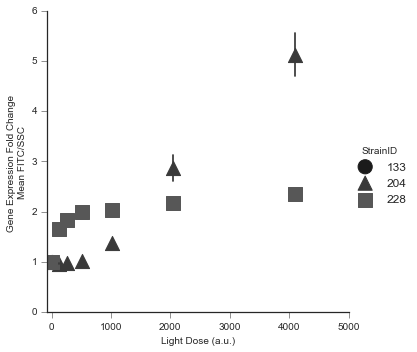

In [16]:
#yLO133 -- SynTF-CLASP
#yLO204 -- Pho4-CLASP
#yLO228 -- Msn2-CLASP
#The dose selected for each strain was marked red in illustrator
seq_col_brew = sns.color_palette("Greys_r", 10)
sns.set_palette(seq_col_brew)
sns.lmplot('Light Dose', 'variable',
           data=strainRespDF_3a, fit_reg=False, size = 5,
           x_estimator=np.mean, x_ci=68, hue="StrainID", 
           markers = ["o","^", "s"], scatter_kws={"marker": "D",
                        "s": 200})
plt.xlabel('Light Dose (a.u.)')
plt.ylabel('Gene Expression Fold Change \nMean FITC/SSC')
plt.ylim(0,6)
plt.xlim(-75, 5000)
dest = date0 + '_AmpResp_ylim6'
#plt.savefig(os.getcwd() + "/" + dest + '.svg',dpi=300)
#plt.savefig(os.getcwd() + "/"  + dest + '.png',dpi=300)

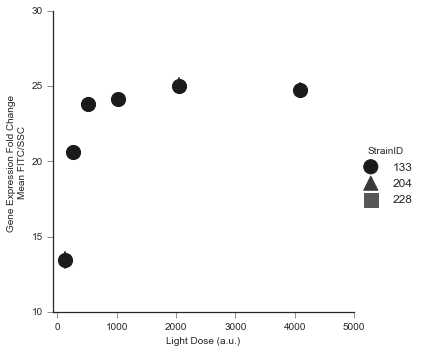

In [17]:
#yLO133 -- SynTF-CLASP
#yLO204 -- Pho4-CLASP
#yLO228 -- Msn2-CLASP
#The dose selected for each strain was marked red in illustrator
seq_col_brew = sns.color_palette("Greys_r", 10)
sns.set_palette(seq_col_brew)
sns.lmplot('Light Dose', 'variable',
           data=strainRespDF_3a, fit_reg=False, size = 5,
           x_estimator=np.mean, x_ci=68, hue="StrainID", 
           markers = ["o","^", "s"], scatter_kws={"marker": "D",
                        "s": 200})
plt.xlabel('Light Dose (a.u.)')
plt.ylabel('Gene Expression Fold Change \nMean FITC/SSC')
plt.ylim(10,30)
plt.xlim(-75, 5000)
dest = date0 + '_AmpResp_ylim10-30'
#plt.savefig(os.getcwd() + "/" + dest + '.svg',dpi=300)
#plt.savefig(os.getcwd() + "/"  + dest + '.png',dpi=300)

# Supplementary Figure 3B

In [18]:
date1 = '20180528_0612_13_14_21'
#load platemaps which detail the location of each strain and dose for syntf and pho4
pTimeMap_133204_1, pCtrlMap_133204_1, pDarkMap_133204_1 = [pd.read_csv(x) for x in 
                                                glob.glob(dataRepo1 + '20180528_LVTRPLANS_durResp_133204_ctrls/PlateMap*.csv')]
pTimeMap_133204_2, pDark_CtrlMap_133204_2 = [pd.read_csv(x) for x in 
                                             glob.glob(dataRepo1 + '20180612_lvtrplans_durResp_133204_ctrls/PlateMap*.csv')]
pTimeMap_133204_3, pDark_CtrlMap_133204_3 = [pd.read_csv(x) for x in 
                                             glob.glob(dataRepo1 + '20180614_lvtrplans_durResp_133204_ctrls/PlateMap*.csv')]

#load platemaps which detail the location of each strain and dose for msn2
pTimeMap_228yps_1, pDark_CtrlMap_228yps_1 = [pd.read_csv(x) for x in 
                                             glob.glob(dataRepo1 + '20180613_lvtrplans_durResp_228yps_ctrls/PlateMap*.csv')]
pTimeMap_228yps_2, pDark_CtrlMap_228yps_2 = [pd.read_csv(x) for x in 
                                             glob.glob(dataRepo1 + '20180614_lvtrplans_durResp_228yps_ctrls/PlateMap*.csv')]
pTimeMap_228yps_3, pDark_CtrlMap_228yps_3 = [pd.read_csv(x) for x in 
                                             glob.glob(dataRepo1 + '20180621_lvtrplans_durResp_228yps_ctrls/PlateMap*.csv')]

In [19]:
#save the names of the directories which hold the actual flow cytometry data

datadir_133204_1_1 = dataRepo1 + '20180528_LVTRPLANS_durResp_133204_ctrls/P1/'
datadir_133204_1_2 = dataRepo1 + '20180528_LVTRPLANS_durResp_133204_ctrls/PDark/'
datadir_133204_1_3 = dataRepo1 + '20180528_LVTRPLANS_durResp_133204_ctrls/PCtrls/'
datadir_133204_2_1 = dataRepo1 + '20180612_lvtrplans_durResp_133204_ctrls/P1/'
datadir_133204_2_2 = dataRepo1 + '20180612_lvtrplans_durResp_133204_ctrls/PDark_Ctrls/'
datadir_133204_3_1 = dataRepo1 + '20180614_lvtrplans_durResp_133204_ctrls/P1/'
datadir_133204_3_2 = dataRepo1 + '20180614_lvtrplans_durResp_133204_ctrls/PDark_Ctrls/'

datadir_228yps_1_1 = dataRepo1 + '20180613_lvtrplans_durResp_228yps_ctrls/P1/'
datadir_228yps_1_2 = dataRepo1 + '20180613_lvtrplans_durResp_228yps_ctrls/PDark_Ctrls/'
datadir_228yps_2_1 = dataRepo1 + '20180614_lvtrplans_durResp_228yps_ctrls/P1/'
datadir_228yps_2_2 = dataRepo1 + '20180614_lvtrplans_durResp_228yps_ctrls/PDark_Ctrls/'
datadir_228yps_3_1 = dataRepo1 + '20180621_lvtrplans_durResp_228yps_ctrls/P1/'
datadir_228yps_3_2 = dataRepo1 + '20180621_lvtrplans_durResp_228yps_ctrls/PDark_Ctrls/'


In [20]:
#save the names of the files within directories which hold the actual flow cytometry data
datadir_list_3b = [datadir_133204_1_1, datadir_133204_1_2, datadir_133204_1_3, datadir_133204_2_1, datadir_133204_2_2, 
                datadir_133204_3_1, datadir_133204_3_2, datadir_228yps_1_1, datadir_228yps_1_2, datadir_228yps_2_1, 
                datadir_228yps_2_2, datadir_228yps_3_1, datadir_228yps_3_2]

[files_133204_1_1, files_133204_1_2, files_133204_1_3, files_133204_2_1, files_133204_2_2, 
              files_133204_3_1, files_133204_3_2, files_228yps_1_1, files_228yps_1_2, files_228yps_2_1, 
              files_228yps_2_2, files_228yps_3_1, files_228yps_3_2] = [glob.glob(x + '*.fcs') for x in datadir_list_3b]

In [21]:
#load flow cytometry data into a plate layout
[plateraw_P1_133204_1, plateraw_PD_133204_1, plateraw_PC_133204_1, 
 plateraw_P1_133204_2, plateraw_PD_C_133204_2, plateraw_P1_133204_3, plateraw_PD_C_133204_3, 
 plateraw_P1_228yps_1, plateraw_PD_C_228yps_1, plateraw_P1_228yps_2, 
 plateraw_PD_C_228yps_2, plateraw_P1_228yps_3, plateraw_PD_C_228yps_3] = [pd.DataFrame(index = rows) for i in range(13)]

files_list_3b = [files_133204_1_1, files_133204_1_2, files_133204_1_3, files_133204_2_1, files_133204_2_2, 
              files_133204_3_1, files_133204_3_2, files_228yps_1_1, files_228yps_1_2, files_228yps_2_1, 
              files_228yps_2_2, files_228yps_3_1, files_228yps_3_2]
plateraw_list_3b = [plateraw_P1_133204_1, plateraw_PD_133204_1, plateraw_PC_133204_1, 
                 plateraw_P1_133204_2, plateraw_PD_C_133204_2, plateraw_P1_133204_3, plateraw_PD_C_133204_3, 
                 plateraw_P1_228yps_1, plateraw_PD_C_228yps_1, plateraw_P1_228yps_2, 
                 plateraw_PD_C_228yps_2, plateraw_P1_228yps_3, plateraw_PD_C_228yps_3]

#parse file names to get plate location
parseFilenamesPlateRaw(files_list_3b, plateraw_list_3b)

In [22]:
[platesort_P1_133204_1, platesort_PD_133204_1, platesort_PC_133204_1, platesort_P1_133204_2, 
 platesort_PD_C_133204_2, platesort_P1_133204_3, platesort_PD_C_133204_3, platesort_P1_228yps_1, 
 platesort_PD_C_228yps_1, platesort_P1_228yps_2, platesort_PD_C_228yps_2, platesort_P1_228yps_3, 
 platesort_PD_C_228yps_3] = [plateraw.loc[rows,cols] for plateraw in plateraw_list_3b]

platesort_133204 = [platesort_P1_133204_1, platesort_PD_133204_1, platesort_PC_133204_1, platesort_P1_133204_2, 
 platesort_PD_C_133204_2, platesort_P1_133204_3, platesort_PD_C_133204_3]

platesort_228yps = [platesort_P1_228yps_1, platesort_PD_C_228yps_1, platesort_P1_228yps_2, 
                    platesort_PD_C_228yps_2, platesort_P1_228yps_3, platesort_PD_C_228yps_3]

In [23]:
#calculate normalized stats for FITC and mCherry from each experiment
#gate data for flow cytometry experiments on FITC (>=100, or approx bkg fluorescence) and side scatter (>= 2000)
[[FITCnorm_P1_133204_1, mCherrynorm_P1_133204_1], [FITCnorm_PD_133204_1, mCherrynorm_PD_133204_1], 
 [FITCnorm_PC_133204_1, mCherrynorm_PC_133204_1], [FITCnorm_P1_133204_2, mCherrynorm_P1_133204_2], 
 [FITCnorm_PD_C_133204_2, mCherrynorm_PD_C_133204_2], [FITCnorm_P1_133204_3, mCherrynorm_P1_133204_3], 
 [FITCnorm_PD_C_133204_3, mCherrynorm_PD_C_133204_3]] = [FCdatastats(platesort,1,rows,cols,100,0,2000) 
                                                         for platesort in platesort_133204]

[[FITCnorm_P1_228yps_1, mCherrynorm_P1_228yps_1], [FITCnorm_PD_C_228yps_1, mCherrynorm_PD_C_228yps_1], 
 [FITCnorm_P1_228yps_2, mCherrynorm_P1_228yps_2], [FITCnorm_PD_C_228yps_2, mCherrynorm_PD_C_228yps_2], 
 [FITCnorm_P1_228yps_3, mCherrynorm_P1_228yps_3], 
 [FITCnorm_PD_C_228yps_3, mCherrynorm_PD_C_228yps_3]] = [FCdatastats(platesort,1,rows,cols,100,0,2000) 
                                                         for platesort in platesort_228yps]

In [24]:
#parse platemaps and get location of technical replicates
pDMapRowList1_133204_1, pDMapColList1_133204_1, pDMapRowListR1_133204_1, pDMapColListR1_133204_1 = plateMapParseReps(pDarkMap_133204_1, 1)
pCMapRowList1_133204_1, pCMapColList1_133204_1, pCMapRowListR1_133204_1, pCMapColListR1_133204_1 = plateMapParseReps(pCtrlMap_133204_1, 1)
pTimeMapRowList1_133204_1, pTimeMapColList1_133204_1, pTimeMapRowListR1_133204_1, pTimeMapColListR1_133204_1 = plateMapParseReps(pTimeMap_133204_1, 5)
pD_CMapRowList1_133204_2, pD_CMapColList1_133204_2, pD_CMapRowListR1_133204_2, pD_CMapColListR1_133204_2 = plateMapParseReps(pDark_CtrlMap_133204_2, 2)
pTimeMapRowList1_133204_2, pTimeMapColList1_133204_2, pTimeMapRowListR1_133204_2, pTimeMapColListR1_133204_2 = plateMapParseReps(pTimeMap_133204_2, 5)
pD_CMapRowList1_133204_3, pD_CMapColList1_133204_3, pD_CMapRowListR1_133204_3, pD_CMapColListR1_133204_3 = plateMapParseReps(pDark_CtrlMap_133204_3, 2)
pTimeMapRowList1_133204_3, pTimeMapColList1_133204_3, pTimeMapRowListR1_133204_3, pTimeMapColListR1_133204_3 = plateMapParseReps(pTimeMap_133204_3, 5)

pD_CMapRowList1_228yps_1, pD_CMapColList1_228yps_1, pD_CMapRowListR1_228yps_1, pD_CMapColListR1_228yps_1 = plateMapParseReps(pDark_CtrlMap_228yps_1, 2)
pTimeMapRowList1_228yps_1, pTimeMapColList1_228yps_1, pTimeMapRowListR1_228yps_1, pTimeMapColListR1_228yps_1 = plateMapParseReps(pTimeMap_228yps_1, 5)
pD_CMapRowList1_228yps_2, pD_CMapColList1_228yps_2, pD_CMapRowListR1_228yps_2, pD_CMapColListR1_228yps_2 = plateMapParseReps(pDark_CtrlMap_228yps_2, 2)
pTimeMapRowList1_228yps_2, pTimeMapColList1_228yps_2, pTimeMapRowListR1_228yps_2, pTimeMapColListR1_228yps_2 = plateMapParseReps(pTimeMap_228yps_2, 5)
pD_CMapRowList1_228yps_3, pD_CMapColList1_228yps_3, pD_CMapRowListR1_228yps_3, pD_CMapColListR1_228yps_3 = plateMapParseReps(pDark_CtrlMap_228yps_3, 2)
pTimeMapRowList1_228yps_3, pTimeMapColList1_228yps_3, pTimeMapRowListR1_228yps_3, pTimeMapColListR1_228yps_3 = plateMapParseReps(pTimeMap_228yps_3, 5)

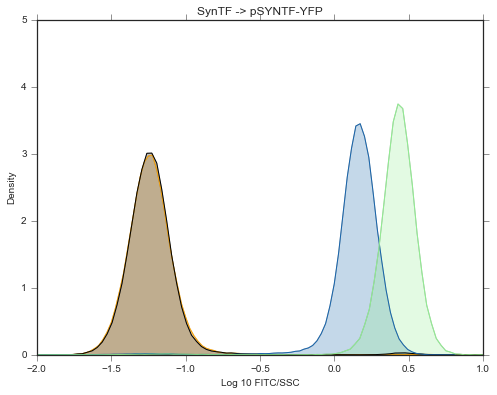

In [26]:
#compare to controls
#plot histograms comparing SynTF-CLASP (133) to SynTF-mScarlet (411) and SynTF-NLS (171) 
seq_col_brew = sns.color_palette("Blues", 4)
sns.set_palette(seq_col_brew)
tf_CLASP_strain = '133'
tf_CytoKO_strain = '411'
tf_NLS_strain = '171'

#concatenate replicates for each strain
#plot FITC for SynTF-mScarlet at dose index 0 (no light) to compare to SynTF-CLASP (no light)
fig, ax = plt.subplots(1, 1,sharex = True, sharey = True, figsize=(8,6))
tfCytoKOReps = pd.concat([concatReplicates(FITCnorm_PC_133204_1, tf_CytoKO_strain, 0, 
                                           pCMapRowList1_133204_1, pCMapColList1_133204_1), 
                concatReplicates(FITCnorm_PD_C_133204_2, tf_CytoKO_strain, 0, pD_CMapRowList1_133204_2, pD_CMapColList1_133204_2), 
                concatReplicates(FITCnorm_PD_C_133204_2, tf_CytoKO_strain, 0, pD_CMapRowListR1_133204_2, pD_CMapColListR1_133204_2),
                concatReplicates(FITCnorm_PD_C_133204_3, tf_CytoKO_strain, 0, pD_CMapRowList1_133204_3, pD_CMapColList1_133204_3), 
                concatReplicates(FITCnorm_PD_C_133204_3, tf_CytoKO_strain, 0, pD_CMapRowListR1_133204_3, pD_CMapColListR1_133204_3)], 
                         ignore_index=True)
#plot the log10 value of normalized FITC
sns.distplot(np.log10(tfCytoKOReps[~np.isnan(tfCytoKOReps)].astype(float)),color = 'orange', 
             ax = ax, hist = False, kde = True, kde_kws = {'shade': True})
#plot for SynTF-CLASP (no light)
tf0Reps = pd.concat([concatReplicates(FITCnorm_PD_133204_1, tf_CLASP_strain, 0, pDMapRowList1_133204_1, pDMapColList1_133204_1), 
                concatReplicates(FITCnorm_PD_133204_1, tf_CLASP_strain, 0, pDMapRowListR1_133204_1, pDMapColListR1_133204_1),
                concatReplicates(FITCnorm_PD_C_133204_2, tf_CLASP_strain, 0, pD_CMapRowList1_133204_2, pD_CMapColList1_133204_2), 
                concatReplicates(FITCnorm_PD_C_133204_2, tf_CLASP_strain, 0, pD_CMapRowListR1_133204_2, pD_CMapColListR1_133204_2),
                concatReplicates(FITCnorm_PD_C_133204_3, tf_CLASP_strain, 0, pD_CMapRowList1_133204_3, pD_CMapColList1_133204_3), 
                concatReplicates(FITCnorm_PD_C_133204_3, tf_CLASP_strain, 0, pD_CMapRowListR1_133204_3, pD_CMapColListR1_133204_3)], 
                    ignore_index=True)
sns.distplot(np.log10(tf0Reps[~np.isnan(tf0Reps)].astype(float)),color = 'black', 
             ax = ax, hist = False, kde = True, kde_kws = {'shade': True})
#plot for SynTF-CLASP (2 hours, index 4) for 1024 au input
tfDoseInd = 4
tf120Reps = pd.concat([concatReplicates(FITCnorm_P1_133204_1, tf_CLASP_strain, tfDoseInd, 
                                        pTimeMapRowList1_133204_1, pTimeMapColList1_133204_1), 
            concatReplicates(FITCnorm_P1_133204_1, tf_CLASP_strain, tfDoseInd, pTimeMapRowListR1_133204_1, pTimeMapColListR1_133204_1), 
            concatReplicates(FITCnorm_P1_133204_2, tf_CLASP_strain, tfDoseInd, pTimeMapRowList1_133204_2, pTimeMapColList1_133204_2), 
            concatReplicates(FITCnorm_P1_133204_2, tf_CLASP_strain, tfDoseInd, pTimeMapRowListR1_133204_2, pTimeMapColListR1_133204_2),
            concatReplicates(FITCnorm_P1_133204_3, tf_CLASP_strain, tfDoseInd, pTimeMapRowList1_133204_3, pTimeMapColList1_133204_3), 
            concatReplicates(FITCnorm_P1_133204_3, tf_CLASP_strain, tfDoseInd, pTimeMapRowListR1_133204_3, pTimeMapColListR1_133204_3)], 
                      ignore_index=True)
sns.distplot(np.log10(tf120Reps[~np.isnan(tf120Reps)].astype(float)), color=seq_col_brew[3], 
                 ax = ax, hist = False, kde = True, kde_kws = {'shade': True})
#plot for SynTF-NLS (2 hours, index 1) for 1024 au input
tfNLSReps = pd.concat([concatReplicates(FITCnorm_PC_133204_1, tf_NLS_strain, 0, 
                                        pCMapRowList1_133204_1, pCMapColList1_133204_1), 
            concatReplicates(FITCnorm_PD_C_133204_2, tf_NLS_strain, 1, pD_CMapRowList1_133204_2, pD_CMapColList1_133204_2), 
            concatReplicates(FITCnorm_PD_C_133204_2, tf_NLS_strain, 1, pD_CMapRowListR1_133204_2, pD_CMapColListR1_133204_2),
            concatReplicates(FITCnorm_PD_C_133204_3, tf_NLS_strain, 1, pD_CMapRowList1_133204_3, pD_CMapColList1_133204_3), 
            concatReplicates(FITCnorm_PD_C_133204_3, tf_NLS_strain, 1, pD_CMapRowListR1_133204_3, pD_CMapColListR1_133204_3)], 
                      ignore_index=True)
sns.distplot(np.log10(tfNLSReps[~np.isnan(tfNLSReps)].astype(float)),color = 'lightgreen', 
             ax = ax, hist = False, kde = True, kde_kws = {'shade': True})

plt.ylim(0,5)
plt.xlim(-2, 1)
plt.xlabel("Log 10 FITC/SSC")
plt.ylabel("Density")
plt.title("SynTF -> pSYNTF-YFP")
dest = date1 + '_synTF_Comp_ctrl_120m_kde'
#plt.savefig(os.getcwd() + "/" + dest + '.svg', bbox_inches='tight',dpi=300)
#plt.savefig(os.getcwd() + "/" + dest + '.png', bbox_inches='tight',dpi=300)

# Supplementary Figure 3C

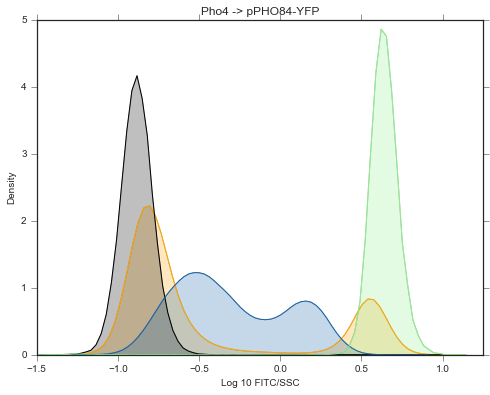

In [27]:
#compare to controls
#plot histograms comparing Pho4-CLASP (204) to Pho4-mScarlet (224) and Pho4-NLS (225) 
seq_col_brew = sns.color_palette("Blues", 4)
sns.set_palette(seq_col_brew)
tf_CLASP_strain = '204'
tf_CytoKO_strain = '224'
tf_NLS_strain = '225'


fig, ax = plt.subplots(1, 1,sharex = True, sharey = True, figsize=(8,6))
#plot FITC for Pho4-mScarlet at dose index 0 (no light) to compare to Pho4-CLASP (no light)
tfCytoKOReps = pd.concat([concatReplicates(FITCnorm_PC_133204_1, tf_CytoKO_strain, 0, 
                                               pCMapRowList1_133204_1, pCMapColList1_133204_1), 
            concatReplicates(FITCnorm_PD_C_133204_2, tf_CytoKO_strain, 0, pD_CMapRowList1_133204_2, pD_CMapColList1_133204_2), 
            concatReplicates(FITCnorm_PD_C_133204_2, tf_CytoKO_strain, 0, pD_CMapRowListR1_133204_2, pD_CMapColListR1_133204_2),
            concatReplicates(FITCnorm_PD_C_133204_3, tf_CytoKO_strain, 0, pD_CMapRowList1_133204_3, pD_CMapColList1_133204_3), 
            concatReplicates(FITCnorm_PD_C_133204_3, tf_CytoKO_strain, 0, pD_CMapRowListR1_133204_3, pD_CMapColListR1_133204_3)], 
                         ignore_index=True)
#plot the log10 value of normalized FITC
sns.distplot(np.log10(tfCytoKOReps[~np.isnan(tfCytoKOReps)].astype(float)),color = 'orange', 
                 ax = ax, hist = False, kde = True, kde_kws = {'shade': True})
#plot for Pho4-CLASP (no light)
tf0Reps = pd.concat([concatReplicates(FITCnorm_PD_133204_1, tf_CLASP_strain, 0, pDMapRowList1_133204_1, pDMapColList1_133204_1), 
            concatReplicates(FITCnorm_PD_133204_1, tf_CLASP_strain, 0, pDMapRowListR1_133204_1, pDMapColListR1_133204_1),
            concatReplicates(FITCnorm_PD_C_133204_2, tf_CLASP_strain, 0, pD_CMapRowList1_133204_2, pD_CMapColList1_133204_2), 
            concatReplicates(FITCnorm_PD_C_133204_2, tf_CLASP_strain, 0, pD_CMapRowListR1_133204_2, pD_CMapColListR1_133204_2),
            concatReplicates(FITCnorm_PD_C_133204_3, tf_CLASP_strain, 0, pD_CMapRowList1_133204_3, pD_CMapColList1_133204_3), 
            concatReplicates(FITCnorm_PD_C_133204_3, tf_CLASP_strain, 0, pD_CMapRowListR1_133204_3, pD_CMapColListR1_133204_3)], 
                    ignore_index=True)
sns.distplot(np.log10(tf0Reps[~np.isnan(tf0Reps)].astype(float)),color = 'black',
                 ax = ax, hist = False, kde = True, kde_kws = {'shade': True})
tfDoseInd = 4
#plot for Pho4-CLASP (2 hours, index 4) for 4095 au input
tf120Reps = pd.concat([concatReplicates(FITCnorm_P1_133204_1, tf_CLASP_strain, tfDoseInd, 
                                        pTimeMapRowList1_133204_1, pTimeMapColList1_133204_1), 
            concatReplicates(FITCnorm_P1_133204_1, tf_CLASP_strain, tfDoseInd, pTimeMapRowListR1_133204_1, pTimeMapColListR1_133204_1), 
            concatReplicates(FITCnorm_P1_133204_2, tf_CLASP_strain, tfDoseInd, pTimeMapRowList1_133204_2, pTimeMapColList1_133204_2), 
            concatReplicates(FITCnorm_P1_133204_2, tf_CLASP_strain, tfDoseInd, pTimeMapRowListR1_133204_2, pTimeMapColListR1_133204_2),
            concatReplicates(FITCnorm_P1_133204_3, tf_CLASP_strain, tfDoseInd, pTimeMapRowList1_133204_3, pTimeMapColList1_133204_3), 
            concatReplicates(FITCnorm_P1_133204_3, tf_CLASP_strain, tfDoseInd, pTimeMapRowListR1_133204_3, pTimeMapColListR1_133204_3)], 
                      ignore_index=True)
sns.distplot(np.log10(tf120Reps[~np.isnan(tf120Reps)].astype(float)), color=seq_col_brew[3], 
                 ax = ax, hist = False, kde = True, kde_kws = {'shade': True})
#plot for Pho4-NLS (2 hours, index 1) for 4095 au input
tfNLSReps = pd.concat([concatReplicates(FITCnorm_PC_133204_1, tf_NLS_strain, 0, pCMapRowList1_133204_1, pCMapColList1_133204_1),
            concatReplicates(FITCnorm_PD_C_133204_2, tf_NLS_strain, 1, pD_CMapRowList1_133204_2, pD_CMapColList1_133204_2), 
            concatReplicates(FITCnorm_PD_C_133204_2, tf_NLS_strain, 1, pD_CMapRowListR1_133204_2, pD_CMapColListR1_133204_2),
            concatReplicates(FITCnorm_PD_C_133204_3, tf_NLS_strain, 1, pD_CMapRowList1_133204_3, pD_CMapColList1_133204_3), 
            concatReplicates(FITCnorm_PD_C_133204_3, tf_NLS_strain, 1, pD_CMapRowListR1_133204_3, pD_CMapColListR1_133204_3)], 
                      ignore_index=True)
sns.distplot(np.log10(tfNLSReps[~np.isnan(tfNLSReps)].astype(float)),color = 'lightgreen', ax = ax, 
                     hist = False, kde = True, kde_kws = {'shade': True})

plt.ylim(0,5)
plt.xlim(-1.5, 1.25)
plt.xlabel("Log 10 FITC/SSC")
plt.ylabel("Density")
plt.title("Pho4 -> pPHO84-YFP")
dest = date1 + '_pho4_Comp_ctrl_120m_kde'
#plt.savefig(os.getcwd() + "/" + dest + '.svg', bbox_inches='tight',dpi=300)
#plt.savefig(os.getcwd() + "/" + dest + '.png', bbox_inches='tight',dpi=300)

# Supplementary Figure 3D

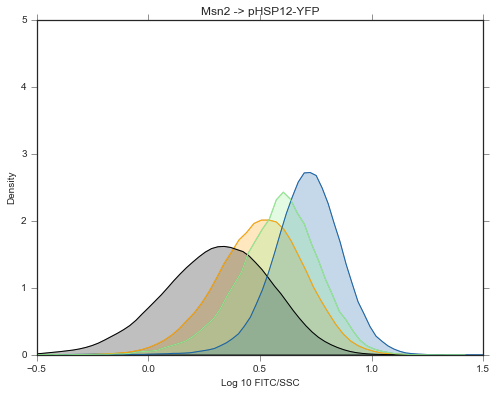

In [28]:
#plot histograms comparing Msn2-CLASP (228) to Msn2-mScarlet (480) and Msn2-NLS (229) 
seq_col_brew = sns.color_palette("Blues", 4)
sns.set_palette(seq_col_brew)
tf_CLASP_strain = '228'
tf_CytoKO_strain = '480'
tf_NLS_strain = '229'

fig, ax = plt.subplots(1, 1,sharex = True, sharey = True, figsize=(8,6))
#concatenate replicates for each strain
#plot FITC for Msn2-mScarlet at dose index 0 (no light) to compare to Msn2-CLASP (no light)
tfCytoKOReps = pd.concat([concatReplicates(FITCnorm_PD_C_228yps_1, tf_CytoKO_strain, 0, 
                                           pD_CMapRowList1_228yps_1, pD_CMapColList1_228yps_1), 
            concatReplicates(FITCnorm_PD_C_228yps_1, tf_CytoKO_strain,0, pD_CMapRowListR1_228yps_1, pD_CMapColListR1_228yps_1),
            concatReplicates(FITCnorm_PD_C_228yps_2, tf_CytoKO_strain, 0, pD_CMapRowList1_228yps_2, pD_CMapColList1_228yps_2), 
            concatReplicates(FITCnorm_PD_C_228yps_2, tf_CytoKO_strain, 0, pD_CMapRowListR1_228yps_2, pD_CMapColListR1_228yps_2), 
            concatReplicates(FITCnorm_PD_C_228yps_3, tf_CytoKO_strain, 0, pD_CMapRowList1_228yps_3, pD_CMapColList1_228yps_3), 
            concatReplicates(FITCnorm_PD_C_228yps_3, tf_CytoKO_strain, 0, pD_CMapRowListR1_228yps_3, pD_CMapColListR1_228yps_3)], 
                         ignore_index=True)
#plot the log10 value of normalized FITC
sns.distplot(np.log10(tfCytoKOReps[~np.isnan(tfCytoKOReps)].astype(float)),color = 'orange', 
             ax = ax, hist = False, kde = True, kde_kws = {'shade': True})
#plot for Msn2-CLASP (no light)
tf0Reps = pd.concat([concatReplicates(FITCnorm_PD_C_228yps_1, tf_CLASP_strain, 0, 
                                      pD_CMapRowList1_228yps_1, pD_CMapColList1_228yps_1), 
            concatReplicates(FITCnorm_PD_C_228yps_1, tf_CLASP_strain, 0, pD_CMapRowListR1_228yps_1, pD_CMapColListR1_228yps_1),
            concatReplicates(FITCnorm_PD_C_228yps_2, tf_CLASP_strain, 0, pD_CMapRowList1_228yps_2, pD_CMapColList1_228yps_2), 
            concatReplicates(FITCnorm_PD_C_228yps_2, tf_CLASP_strain, 0, pD_CMapRowListR1_228yps_2, pD_CMapColListR1_228yps_2),
            concatReplicates(FITCnorm_PD_C_228yps_3, tf_CLASP_strain, 0, pD_CMapRowList1_228yps_3, pD_CMapColList1_228yps_3), 
            concatReplicates(FITCnorm_PD_C_228yps_3, tf_CLASP_strain, 0, pD_CMapRowListR1_228yps_3, pD_CMapColListR1_228yps_3)], 
            ignore_index=True)
sns.distplot(np.log10(tf0Reps[~np.isnan(tf0Reps)].astype(float)),color = 'black', 
             ax = ax, hist = False, kde = True, kde_kws = {'shade': True})
#plot for Msn2-CLASP (2 hours, index 4) for 2048 au input
tfDoseInd = 4
tf120Reps = pd.concat([concatReplicates(FITCnorm_P1_228yps_1, tf_CLASP_strain, tfDoseInd, 
                                        pTimeMapRowList1_228yps_1, pTimeMapColList1_228yps_1), 
            concatReplicates(FITCnorm_P1_228yps_1, tf_CLASP_strain, tfDoseInd, pTimeMapRowListR1_228yps_1, pTimeMapColListR1_228yps_1), 
            concatReplicates(FITCnorm_P1_228yps_2, tf_CLASP_strain, tfDoseInd, pTimeMapRowList1_228yps_2, pTimeMapColList1_228yps_2), 
            concatReplicates(FITCnorm_P1_228yps_2, tf_CLASP_strain, tfDoseInd, pTimeMapRowListR1_228yps_2, pTimeMapColListR1_228yps_2),
            concatReplicates(FITCnorm_P1_228yps_3, tf_CLASP_strain, tfDoseInd, pTimeMapRowList1_228yps_3, pTimeMapColList1_228yps_3), 
            concatReplicates(FITCnorm_P1_228yps_3, tf_CLASP_strain, tfDoseInd, pTimeMapRowListR1_228yps_3, pTimeMapColListR1_228yps_3)], 
                      ignore_index=True)
sns.distplot(np.log10(tf120Reps[~np.isnan(tf120Reps)].astype(float)), color=seq_col_brew[3], 
             ax = ax, hist = False, kde = True, kde_kws = {'shade': True})
#plot for Msn2-NLS (2 hours, index 1) for 2048 au input
tfNLSReps = pd.concat([concatReplicates(FITCnorm_PD_C_228yps_1, tf_NLS_strain, 1,
                                            pD_CMapRowList1_228yps_1, pD_CMapRowList1_228yps_1), 
            concatReplicates(FITCnorm_PD_C_228yps_1, tf_NLS_strain, 1, pD_CMapRowList1_228yps_1, pD_CMapRowList1_228yps_1),
            concatReplicates(FITCnorm_PD_C_228yps_2, tf_NLS_strain, 1,pD_CMapRowList1_228yps_2, pD_CMapRowList1_228yps_2), 
            concatReplicates(FITCnorm_PD_C_228yps_2, tf_NLS_strain, 1, pD_CMapRowList1_228yps_2, pD_CMapRowList1_228yps_2),
            concatReplicates(FITCnorm_PD_C_228yps_3, tf_NLS_strain, 1,pD_CMapRowList1_228yps_3, pD_CMapRowList1_228yps_3), 
            concatReplicates(FITCnorm_PD_C_228yps_3, tf_NLS_strain, 1, pD_CMapRowList1_228yps_3, pD_CMapRowList1_228yps_3)], 
                          ignore_index=True)
sns.distplot(np.log10(tfNLSReps[~np.isnan(tfNLSReps)].astype(float)),color = 'lightgreen', 
                 ax = ax, hist = False, kde = True, kde_kws = {'shade': True})

plt.ylim(0,5)
plt.xlim(-0.5, 1.5)
plt.xlabel("Log 10 FITC/SSC")
plt.ylabel("Density")
plt.title("Msn2 -> pHSP12-YFP")
dest = date1 + '_msn2_Comp_ctrl_120m_kde_3expts'
#plt.savefig(os.getcwd() + "/" + dest + '.svg', bbox_inches='tight',dpi=300)
#plt.savefig(os.getcwd() + "/" + dest + '.png', bbox_inches='tight',dpi=300)

# Supplementary Figure 3E

Images taken from ImageJ

# Supplementary Figure 3F

In [29]:
dose5mnuc_gal4 = pd.read_csv(dataRepo + '20180314_p2CTSeed1_nuc.csv', header=None)
dose5mcyt_gal4 = pd.read_csv(dataRepo + '20180314_p2CTSeed1_cyt.csv', header=None)
dose5mbkg_gal4 = pd.read_csv(dataRepo + '20180314_p2CTSeed1_bkg.csv', header=None)

In [30]:
#adjust DF of brightness by background
def bkgAdj(brightDF, bkgVec):
    brightAdj = brightDF.apply(lambda x: x-bkgVec.iloc[0,:], 0)
    return brightAdj
#calculate nuclear/cytoplasmic enrichment and normalize
def nucEnrich(nucDF, cytoDF):
    nucCytoEnrich = nucDF/cytoDF
    normNCEnrich = nucCytoEnrich.apply(lambda x: x/nucCytoEnrich.iloc[0,:], 1)
    return [nucCytoEnrich, normNCEnrich]

def rmUntrackedCells(nucDF, cytDF, maxUntrackedFrames):
    #untracked cells often have 0 or negative reading (can be used for bkg-adj cells or not adjusted)
    pass0Cutoff_nucDF = nucDF.apply(lambda x: sum(x<=0) > maxUntrackedFrames, 0)
    pass0Cutoff_cytDF = cytDF.apply(lambda x: sum(x<=0) > maxUntrackedFrames, 0)
    nucDF_woOutliers = nucDF.drop(list(np.where(pass0Cutoff_nucDF)[0]), axis=1)
    cytDF_woOutliers =cytDF.drop(list(np.where(pass0Cutoff_nucDF)[0]), axis=1)
    return [nucDF_woOutliers, cytDF_woOutliers]

def rmOutliers(normNCDF, maxNegFrames): 
    #add in removal of cells which have negative values at any point
    passNegCutoffDF = normNCDF.apply(lambda x: sum(x<0) > maxNegFrames, 0)
    normNCDFwoOutliers = normNCDF.drop(list(np.where(passNegCutoffDF)[0]), axis=1)
    return normNCDFwoOutliers

In [31]:
#adjust nuclear and cytoplasmic brightness by background value
d5mnucAdj_gal4 = bkgAdj(dose5mnuc_gal4, dose5mbkg_gal4)
d5mcytAdj_gal4 = bkgAdj(dose5mcyt_gal4, dose5mbkg_gal4)
#remove cells which are untracked for more than 3 frames
d5mnucAdj_gal4_rm_UT, d5mcytAdj_gal4_rm_UT = rmUntrackedCells(d5mnucAdj_gal4, d5mcytAdj_gal4, 3)
#calculate nuclear/cytoplasmic enrichment and normalize to the first frame
d5mnucCytoEnr_gal4_rm_UT, d5mnormNucCytoEnr_gal4_rm_UT = nucEnrich(d5mnucAdj_gal4_rm_UT, d5mcytAdj_gal4_rm_UT)
#remove cells which have negative values at any point
d5mnormNucCytoEnr_gal4_rm2 = rmOutliers(d5mnormNucCytoEnr_gal4_rm_UT, 0)
#turn the dataframe from wide to long and mark the timepoints (images taken every 30s)
longd5mnormNucCyto_gal4_rm2 = pd.melt(d5mnormNucCytoEnr_gal4_rm2)
longd5mnormNucCyto_gal4_rm2["timepoint"] = np.arange(0,d5mnormNucCytoEnr_gal4_rm2.shape[0]/2.0, 
                                                     step=0.5).tolist()*d5mnormNucCytoEnr_gal4_rm2.shape[1]

C:\Users\Lindsey\Miniconda\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


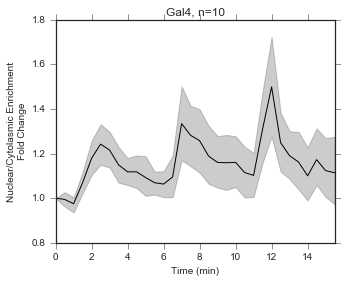

In [32]:
#graphic showing light input was added in illustrator
fig, ax = plt.subplots(1, 1, sharey = True, sharex=True, figsize=(5, 4))
sns.tsplot(data=longd5mnormNucCyto_gal4_rm2, time="timepoint", unit="variable", 
           value="value",err_style='ci_band', ci=95, color="black", ax = ax)
plt.ylim(0.8, 1.8)
plt.xlabel("Time (min)")
plt.ylabel("Nuclear/Cytolasmic Enrichment\nFold Change")
plt.title("Gal4-CLASP, n=" + str(d5mnormNucCytoEnr_gal4_rm2.shape[1]))
date2 = "20180315"
dest = date2 + '_5m_DoseResp'
#plt.savefig(os.getcwd() + "/" + dest + '.svg',dpi=300)
#plt.savefig(os.getcwd() + "/" + dest + '.png',dpi=300)

# Supplementary Figure 3G

In [33]:
date3 = '20171212_1110_1107'
#load platemaps which detail the location of each strain and dose
p2Map_1107, pDarkMap_1107 = [pd.read_csv(x) for x in 
                                    glob.glob(dataRepo + '20171107_LVTRPLANS_Gal4Pho4/PlateMap*.csv')]
p1Map_1110, pDarkMap_1110 = [pd.read_csv(x) for x in 
                                    glob.glob(dataRepo + '20171110_LVTRPLANS_Gal4Pho4/PlateMap*.csv')]
p1Map_1212, pDarkMap_1212 = [pd.read_csv(x) for x in 
                                    glob.glob(dataRepo + '20171212_LVTRPLANS_Gal4Msn2/PlateMap*.csv')]

In [34]:
#save the names of the directories which hold the actual flow cytometry data
datadir1107_2 = dataRepo + "20171107_LVTRPLANS_Gal4Pho4/P2/"
datadir1107_3 = dataRepo + "20171107_LVTRPLANS_Gal4Pho4/P3_noLight/"
datadir1110 = dataRepo + "20171110_LVTRPLANS_Gal4Pho4/P1_3dil/"
datadir1212_1 = dataRepo + "20171212_LVTRPLANS_Gal4Msn2/120m Plate/"
datadir1212_2 = dataRepo + "20171212_LVTRPLANS_Gal4Msn2/Dark Plate/"

In [35]:
#save the names of the files within directories which hold the actual flow cytometry data
datadir_list_3g = [datadir1107_2, datadir1107_3, datadir1110, datadir1212_1, datadir1212_2]
[files_1107_2, files_1107_3, files_1110, files_1212_1, files_1212_2] = [glob.glob(x + '*.fcs') for x in datadir_list_3g]

In [36]:
#load flow cytometry data into a plate layout
[plateraw_P2_1107, plateraw_PD_1107, plateraw_1110,
 plateraw_P1_1212, plateraw_PD_1212] = [pd.DataFrame(index = rows) for i in range(5)]
files_list_3g = [files_1107_2, files_1107_3, files_1110, files_1212_1, files_1212_2]
plateraw_list_3g = [plateraw_P2_1107, plateraw_PD_1107, plateraw_1110, plateraw_P1_1212, plateraw_PD_1212]

#parse file names to get plate location
parseFilenamesPlateRaw(files_list_3g, plateraw_list_3g)

In [37]:
[platesort_P2_1107, platesort_PD_1107, platesort_1110, 
 platesort_P1_1212, platesort_PD_1212] = [plateraw.loc[rows,cols] for plateraw in plateraw_list_3g]

platesort_3g = [platesort_P2_1107, platesort_PD_1107, platesort_1110, platesort_P1_1212, platesort_PD_1212]

In [44]:
#calculate normalized stats for FITC and mCherry from each experiment
#gate data for flow cytometry experiments on FITC (>=100, or approx bkg fluorescence) and side scatter (>= 2000)
[[FITCnorm_P2_1107, mCherrynorm_P2_1107], [FITCnorm_PD_1107, mCherrynorm_PD_1107], 
 [FITCnorm_1110, mCherrynorm_1110], [FITCnorm_P1_1212, mCherrynorm_P1_1212], 
 [FITCnorm_PD_1212, mCherrynorm_PD_1212]] = [FCdatastats(platesort,1,rows,cols,100,0,2000) 
                                                         for platesort in platesort_3g]

In [45]:
#parse platemaps
p2MapRowList_1107, p2MapColList_1107 = plateMapParse(p2Map_1107, 5)
pDarkMapRowList_1107, pDarkMapColList_1107 = plateMapParse(pDarkMap_1107, 1)
p1MapRowList_1110, p1MapColList_1110 = plateMapParse(p1Map_1110, 8)
pDarkMapRowList_1110, pDarkMapColList_1110 = plateMapParse(pDarkMap_1110, 1)
p1MapRowList_1212, p1MapColList_1212 = plateMapParse(p1Map_1212, 5)
pDarkMapRowList_1212, pDarkMapColList_1212 = plateMapParse(pDarkMap_1212, 1)

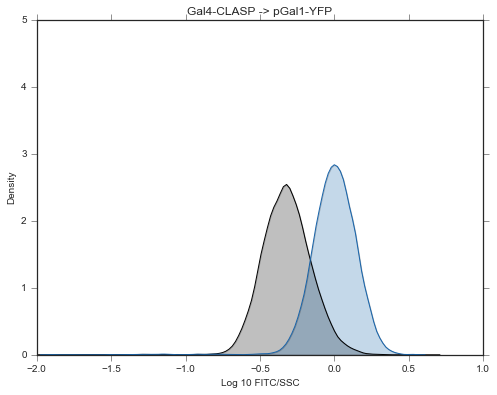

In [48]:
seq_col_brew = sns.color_palette("Blues", 4)
sns.set_palette(seq_col_brew)
#set strain name; all experiments use a 4 hour outgrowth, but this is specifically notated in 1107 expt
strain_name = '177'
strain_name_outgrowth = strain_name + '_4h'
fig, ax = plt.subplots(1, 1,sharex = True, sharey = True, figsize=(8,6))
#there are no replicates in each experiment, so concatenate for each experiment
#plot FITC for Gal4-mScarlet at dose index 0 (no light)
tf0Reps = pd.concat([FITCnorm_PD_1107.raw.iloc[pDarkMapRowList_1107[0][strain_name_outgrowth],
                          pDarkMapColList_1107[0][strain_name_outgrowth]], 
           FITCnorm_1110.raw.iloc[pDarkMapRowList_1110[0][strain_name],
                          pDarkMapColList_1110[0][strain_name]], 
           FITCnorm_PD_1212.raw.iloc[pDarkMapRowList_1212[0][strain_name],
                          pDarkMapColList_1212[0][strain_name]]], ignore_index=True)
#plot the log10 value of normalized FITC
sns.distplot(np.log10(tf0Reps[~np.isnan(tf0Reps)].astype(float)),color = 'black', 
             ax = ax, hist = False, kde = True, kde_kws = {'shade': True})
#plot for Gal4-CLASP ( light)
tfDoseInd = 3
tf120Reps = pd.concat([FITCnorm_P2_1107.raw.iloc[p2MapRowList_1107[tfDoseInd][strain_name_outgrowth],
                          p2MapColList_1107[tfDoseInd][strain_name_outgrowth]], 
           FITCnorm_1110.raw.iloc[p1MapRowList_1110[tfDoseInd][strain_name],
                          p1MapColList_1110[tfDoseInd][strain_name]], 
           FITCnorm_P1_1212.raw.iloc[p1MapRowList_1212[tfDoseInd][strain_name],
                          p1MapColList_1212[tfDoseInd][strain_name]]], ignore_index=True)
sns.distplot(np.log10(tf120Reps[~np.isnan(tf120Reps)].astype(float)),color = seq_col_brew[3], 
             ax = ax, hist = False, kde = True, kde_kws = {'shade': True})
plt.ylim(0,5)
plt.xlim(-2.0, 1.0)
plt.xlabel("Log 10 FITC/SSC")
plt.ylabel("Density")
plt.title("Gal4-CLASP -> pGal1-YFP")
dest = date3 + '_gal4CLASP_120m_kde_3expts'
#plt.savefig(os.getcwd() + "/" + dest + '.svg', bbox_inches='tight',dpi=300)
#plt.savefig(os.getcwd() + "/" + dest + '.png', bbox_inches='tight',dpi=300)